In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, compute_meandice
from monai.networks.nets import UNet
import torch
import torch.nn as nn
import numpy as np
import os
import torch.optim as opt
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import cv2
import h5py
from scipy.ndimage.interpolation import zoom
import torchvision.transforms as T
import random
from scipy.ndimage.interpolation import zoom

In [3]:
base = './'
data_path = [base + 'train/' + x for x in os.listdir(base + 'train/')]
names = [x.split('/')[-1].split('_')[0] for x in data_path]
counts = pd.Series(names).value_counts().to_dict()
templete =  './train/{x}_{y}.h5'
train_paths = []
for name in counts.keys():
    count = counts[name]
    for i in range(1, count-2):
        temp = []
        for j in range(i-1, i+2):
            temp.append(templete.format(x=name, y=j))
        train_paths.append(temp)

In [4]:
base = './'
data_path = [base + 'val/' + x for x in os.listdir(base + 'val/')]
names = [x.split('/')[-1].split('_')[0] for x in data_path]
counts = pd.Series(names).value_counts().to_dict()
templete =  './val/{x}_{y}.h5'
val_paths = []
for name in counts.keys():
    count = counts[name]
    for i in range(1, count-2):
        temp = []
        for j in range(i-1, i+2):
            temp.append(templete.format(x=name, y=j))
        val_paths.append(temp)

In [4]:
np.array(train_paths).shape, np.array(val_paths).shape

((10942, 3), (2745, 3))

In [5]:
class segmentation(torch.utils.data.Dataset):
    def __init__(self, paths, aug=False, train=True):
        self.paths = paths
        self.train = train
        self.aug = aug
        
    def __getitem__(self, idx):
        paths = self.paths[idx]
        xs = []
        f = h5py.File(paths[1], 'r')
        y = f['gt'][:]
        y = torch.from_numpy(y)
        y = y.float().view(1, 400, 400)
        f.close()
        for path in paths:
            f = h5py.File(path, 'r')
            x = f['ct'][:].astype(np.float)
            x = torch.from_numpy(x)
            x = x.float().view(1, 400, 400)
            xs.append(x)  
            f.close()
        x = torch.cat(xs, dim=0)
        return x, y
        
    def __len__(self):
        return len(self.paths)
    
def one_hot(labels: torch.Tensor, num_classes: int, dtype: torch.dtype = torch.float, dim: int = 1) -> torch.Tensor:
    # if `dim` is bigger, add singleton dim at the end
    if labels.ndim < dim + 1:
        shape = list(labels.shape) + [1] * (dim + 1 - len(labels.shape))
        labels = torch.reshape(labels, shape)

    sh = list(labels.shape)

    if sh[dim] != 1:
        raise AssertionError("labels should have a channel with length equal to one.")

    sh[dim] = num_classes

    o = torch.zeros(size=sh, dtype=dtype, device=labels.device)
    labels = o.scatter_(dim=dim, index=labels.long(), value=1)

    return labels


In [10]:
class Trainer():
    def __init__(self,model,train_set,test_set,opts):
        self.model = model  # neural net
        # device agnostic code snippet
        self.device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.model.to(self.device)
        
        self.epochs = opts['epochs']
        self.optimizer = torch.optim.Adam(model.parameters(), opts['lr'], weight_decay=1e-1)
        self.criterion = DiceLoss(to_onehot_y=True, softmax=True, squared_pred=False)                     # loss function
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                        batch_size=opts['batch_size'],
                                                        shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                       batch_size=opts['batch_size'],
                                                       shuffle=False)
        #self.tb = SummaryWriter(log_dir='./runs/single_pet/')
        self.best_loss = 1e10
        
    def train(self):
        for epoch in range(self.epochs):
            self.model.train() #put model in training mode
            self.tr_loss = []
            for i, (data,labels) in tqdm(enumerate(self.train_loader),
                                                   total = len(self.train_loader)):
                data, labels = data.to(self.device),labels.to(self.device)
                self.optimizer.zero_grad()  
                outputs = self.model(data)   
                loss = self.criterion(outputs, labels) 
                loss.backward()                        
                self.optimizer.step()                  
                self.tr_loss.append(loss.item())
                #self.tb.add_scalar("Train Loss", np.mean(self.tr_loss), epoch)
            
            self.test(epoch) # run through the validation set
        self.tb.close()
            
    def test(self,epoch):
            
            self.model.eval()    # puts model in eval mode - not necessary for this demo but good to know
            self.test_loss = []
            self.test_dice = []
            self.test_acc = []
            
            for i, (data, labels) in enumerate(self.test_loader):
                
                data, labels = data.to(self.device),labels.to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(data)
                loss = self.criterion(outputs, labels)
                self.test_loss.append(loss.item())
                outputs = torch.nn.functional.softmax(outputs, 1)
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted.view(-1, 1, 400, 400)
                temp_dice = compute_meandice(one_hot(predicted, 2), one_hot(labels, 2), include_background=False).detach().cpu().numpy()
                if np.nanmean(temp_dice) == np.nanmean(temp_dice):
                    self.test_dice.append(np.nanmean(temp_dice))
                self.test_acc.append((predicted == labels).sum().item() / (predicted.size(0)*400*400))
               
            print('epoch: {}, train loss: {}, test loss: {}'.format( 
                  epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss)))
            print('epoch: {}, test dice: {}, test acc: {}'.format( 
                  epoch+1, np.nanmean(self.test_dice), np.mean(self.test_acc)))           
            #self.tb.add_scalar("Val Loss", np.mean(self.test_loss), epoch)
            #self.tb.add_scalar("Val dice", np.nanmean(self.test_dice), epoch)
            #self.tb.add_scalar("Val acc", np.mean(self.test_acc), epoch)
            if np.mean(self.test_loss) < self.best_loss:
                self.best_loss = np.mean(self.test_loss)
                #torch.save(self.model, './model_weights/best_single_pet.pt')

In [11]:
model = UNet(
    dimensions=2,
    in_channels=3,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
)

In [12]:

train_set, val_set = segmentation(train_paths[:1000]), segmentation(val_paths[:1000], train=False)

opts = {
    'lr': 1e-3,
    'epochs': 40,
    'batch_size': 64
}
train = Trainer(model, train_set, val_set, opts)
train.train()

cuda:4



epoch: 1, train loss: 0.6071649305522442, test loss: 0.5804989486932755
epoch: 1, test dice: 0.16729779541492462, test acc: 0.7071407543945313



epoch: 2, train loss: 0.5655348226428032, test loss: 0.5447463355958462
epoch: 2, test dice: 0.21218684315681458, test acc: 0.7521747192382813



epoch: 3, train loss: 0.5307183526456356, test loss: 0.5150115303695202
epoch: 3, test dice: 0.25297439098358154, test acc: 0.7820313146972656



epoch: 4, train loss: 0.5064774379134178, test loss: 0.49236106500029564
epoch: 4, test dice: 0.3016684651374817, test acc: 0.8249934350585937



epoch: 5, train loss: 0.48405149951577187, test loss: 0.4762161523103714
epoch: 5, test dice: 0.3692920207977295, test acc: 0.8746707910156251



epoch: 6, train loss: 0.47112196311354637, test loss: 0.4648300465196371
epoch: 6, test dice: 0.38969510793685913, test acc: 0.8858330212402343



epoch: 7, train loss: 0.4494025129824877, test loss: 0.44119921885430813
epoch: 7, test dice: 0.43554359674453735, test acc: 0.9031895568847657



epoch: 8, train loss: 0.43156752549111843, test loss: 0.4236883111298084
epoch: 8, test dice: 0.5341923236846924, test acc: 0.9439286633300781



epoch: 9, train loss: 0.41496594436466694, test loss: 0.40164538845419884
epoch: 9, test dice: 0.5467924475669861, test acc: 0.9446954431152343


KeyboardInterrupt: 

In [ ]:
f = h5py.File('./train/1110024639_157.h5', 'r')
y = f['gt'][:]
f.close()

In [29]:
np.unique(y)
y[y < 0] = 0
print(np.unique(y))
y = zoom(y, np.array([400, 400])/y.shape)
y[y < 0] = 0
print(np.unique(y))

[0 1]
[0 1]


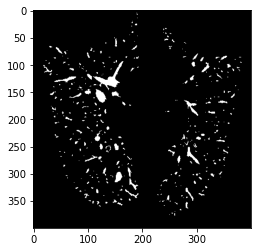

In [31]:
plt.imshow(y, cmap='gray')

In [3]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [4]:
params

1625737